In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as pl
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
import pickle
from ocolorutils import MakeParula
from matplotlib.pylab import rcParams
parula = MakeParula()

In [2]:
%matplotlib inline

In [3]:
maindir='/disk02/UNCERTAINTIES/Monte-Carlo/MODIS/DATA/Chesapeake/L2/'

In [4]:
fnStd = maindir + 'Standard/A2003118181500.L2'
stdSaveDir = maindir + 'Standard/Maps/'

In [5]:
with nc.Dataset(fnStd) as ds:
    gpNavV = ds.groups['navigation_data'].variables
    gpGeoV = ds.groups['geophysical_data'].variables
    lats = gpNavV['latitude'][:]
    lons = gpNavV['longitude'][:]
    chlora = gpGeoV['chlor_a'][:]
    #chloraUnc = gpGeoV['chlor_a_unc'][:]
    rrs443 = gpGeoV['Rrs_443'][:]
    rrs443Unc = gpGeoV['Rrs_unc_443'][:]
    rrs488 = gpGeoV['Rrs_488'][:]
    rrs488Unc = gpGeoV['Rrs_unc_488'][:]
    rrs531 = gpGeoV['Rrs_531'][:]
    rrs531Unc = gpGeoV['Rrs_unc_531'][:]
    rrs547 = gpGeoV['Rrs_547'][:]
    rrs547Unc = gpGeoV['Rrs_unc_547'][:]
chloraUnc = np.load('chloraUnc1.pkl')

In [7]:
lonRng=(-77.25,-75.60)
latRng=(36.75,39.64)

In [9]:
import os
figsavedir = os.path.join('/disk02/UNCERTAINTIES/Monte-Carlo/MODIS/','MODISMeeting2016',
                          'Figs','Ches')

In [10]:
import seaborn as sb
from matplotlib.pylab import rcParams
rcParams['xtick.labelsize']=20
rcParams['ytick.labelsize']=20

In [10]:
newchlmask = np.ma.mask_or(chlora.mask,chloraUnc.mask)
x = np.ma.array(chlora.data,mask=newchlmask)
y = np.ma.array(chloraUnc.data,mask=newchlmask)

In [54]:
print(Hmasked.min(),Hmasked.max())
dataRng=Hmasked.min(),100

1.0 297745.0


In [85]:
# randomly subsample x,y by index
idx = np.random.choice(x.compressed().shape[0],size=40000,replace=False)
xs,ys=x.compressed()[idx],y.compressed()[idx]

In [86]:
from scipy.stats import gaussian_kde
xy=np.vstack([xs,ys])
z = gaussian_kde(xy)(xy)

In [87]:
idx=z.argsort()
xs,ys,z = xs[idx],ys[idx],z[idx]

In [88]:
dataRng = z.min(),z.max()

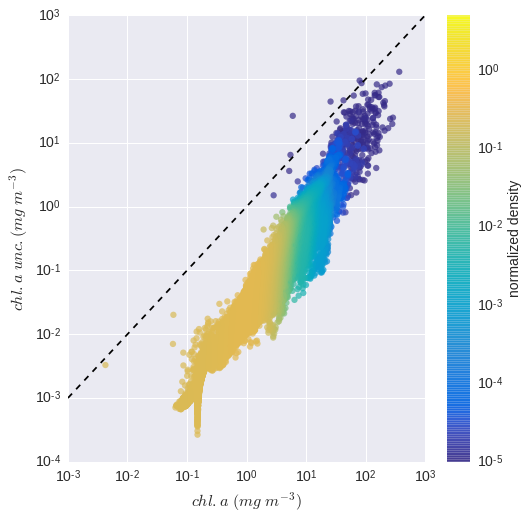

In [130]:
sb.set_style('darkgrid')
norm = colors.LogNorm(vmin=1e-5,vmax=5)
ssn=pl.cm.ScalarMappable()
ssn.set_cmap(parula)
ssn.set_clim((1e-5,5))
f,ax=pl.subplots(ncols=1,figsize=(8,8))
#ax[0].plot(nChl.compressed(),nChlU.compressed(),'.k')
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
ax.set_ylabel(r'$chl. a \ unc. (mg \ m^{-3})$',fontsize=16)
ax.set_xlabel(r'$chl. a \ (mg \ m^{-3})$',fontsize=16)
#ax.set_ylim((0,100))
#pl.scatter()
sc = ax.scatter(xs,ys,c=z,cmap=ssn.cmap,norm=norm,s=40,edgecolor='',alpha=0.7)
cb = pl.colorbar(sc,ax=ax)
cb.set_label('normalized density',size=14)
ax.set_xlim((1e-3,1e3))
ax.set_ylim((1e-4,1e3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([1e-3,1e3],[1e-3,1e3],ls='--',color='k');

In [ ]:
pl.hist()

In [18]:
def DrawDists(data,dataU,rngL,rngR,fname,ttlL,ttlR,figsavedir,**kwargs):
    
    if rngL is None:
        rngL = (data.min(),data.max())
    if rngR is None:
        rngR = (data.min(),data.max())
    leftLog = kwargs.pop('leftLog',False)
    rightLog = kwargs.pop('rightLog',False) 
    figsize = kwargs.pop('figsize',(12,6))
    xlabL = kwargs.pop('xlabL',r'$sr^{-1}$')
    xlabR = kwargs.pop('xlabR',r'$sr^{-1}$')
    returnNP = kwargs.pop('retnp',False)
    f,axs=pl.subplots(ncols=2,figsize=figsize)
    binsL = 100
    binsR = 50
    ylogL = False
    ylogR = False
    if leftLog:
        binsL = np.logspace(np.log10(rngL[0]),np.log10(rngL[-1]),binsL)
        ylogL = True
    if rightLog:
        ylogR = True
        binsR = np.logspace(np.log10(rngR[0]),np.log10(rngR[-1]),binsR)
    n0,bins0,_ = axs[0].hist(data.compressed(),bins=binsL,range=rngL,histtype='stepfilled',
               normed=True,log=ylogL);
    axs[0].set_xlabel(xlabL,fontsize=22)
    axs[0].set_ylabel(r'$freq.$',fontsize=22)
    #axs[0].set_title(ttlL,fontsize=28)
    #axs[0].set_xlim(xmin=-.5,xmax=1)
    n1,bins1,_ = axs[1].hist(dataU.compressed(),bins=50,range=rngR,log=ylogR
                ,histtype='stepfilled',normed=True)
    axs[1].set_xlabel(xlabR,fontsize=22)
    #axs[1].set_title(ttlR,fontsize=28)
    #axs[1].xaxis.set_ticks(np.arange(0.4,2.2,0.4)*1e-4)
    #axs[1].set_xlim(xmin=0.03,xmax=0.07)
    if leftLog:
        axs[0].set_xscale('log')
    else:
        axs[0].ticklabel_format(axis='both',style='sci',scilimits=(-2,3))
    if rightLog:
        axs[1].set_xscale('log')
    else:
        axs[1].ticklabel_format(axis='both',style='sci',scilimits=(-2,3))
    savepath = os.path.join(figsavedir,fname)
    f.savefig(savepath,dpi=300)
    if returnNP:
        return bins0,bins1,binsL,binsR,n0,n1

In [12]:
def DrawMap(data,title,fname,dataRng,figsavedir,**kwargs):
    figsz = kwargs.pop('figsz',(6,8))
    normscale = kwargs.pop('normscale',True)
    lbl = kwargs.pop('lbl',r'$sr^{-1}$')
    fig,ax = pl.subplots(figsize=(6,8))
    msn = Basemap(llcrnrlon=lonRng[0],llcrnrlat=latRng[0],
                 urcrnrlon=lonRng[1],urcrnrlat=latRng[1],resolution='h',ax=ax)
    msn.drawmeridians(np.arange(240,280,10),labels=[False]*3+[True])
    msn.drawparallels(np.arange(-30,-10,10),labels=[True]+3*[False])
    msn.drawmapboundary(fill_color='0.3')
    msn.drawcoastlines()
    ssn=pl.cm.ScalarMappable()
    ssn.set_cmap('cubehelix')
    ssn.set_clim(dataRng)
    powerlims = True
    if normscale:
        norm = colors.Normalize(vmin=dataRng[0], vmax=dataRng[1])
    else:
        norm = colors.LogNorm(vmin=dataRng[0],vmax=dataRng[1])
        powerlims = False
    im = msn.pcolormesh(lons, lats, data, cmap=ssn.cmap,
                        latlon=True, norm=norm)
    cb = msn.colorbar(im);
    cb.set_label(lbl,size=20)
    if powerlims:
        cb.formatter.set_powerlimits((-1,3))
        cb.update_ticks()
    ax.set_title(title,fontsize = 28)
    fnpath = os.path.join(figsavedir,fname)
    fig.savefig(fnpath,dpi=300)

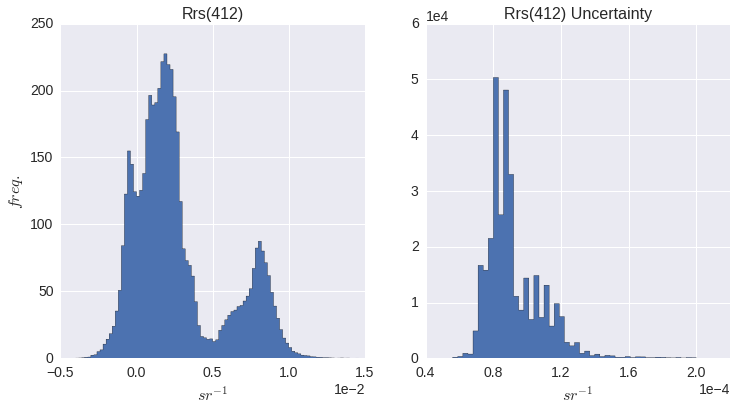

In [23]:
# Rrs 412 Dists
f,axs=pl.subplots(ncols=2,figsize=(12,6))
axs[0].hist(rrs412.compressed(),bins=100,range=(-5e-3,1.5e-2),histtype='stepfilled',
           normed=True);
axs[0].set_xlabel(r'$sr^{-1}$',fontsize=16)
axs[0].set_ylabel(r'$freq.$',fontsize=16)
axs[0].set_title('Rrs(412)',fontsize=16)
#axs[0].set_xlim(xmin=-.5,xmax=1)
axs[1].hist(rrs412Unc.compressed(),bins=50,range=(0.5e-4,2e-4)
            ,histtype='stepfilled',normed=True)
axs[1].set_xlabel(r'$sr^{-1}$',fontsize=16)
axs[1].set_title('Rrs(412) Uncertainty',fontsize=16)
axs[1].xaxis.set_ticks(np.arange(0.4,2.2,0.4)*1e-4)
#axs[1].set_xlim(xmin=0.03,xmax=0.07)
for ax in axs: 
    ax.ticklabel_format(axis='both',style='sci',scilimits=(-2,3))
savepath = os.path.join(figsavedir,'rrs412dists.png')
f.savefig(savepath,dpi=300)

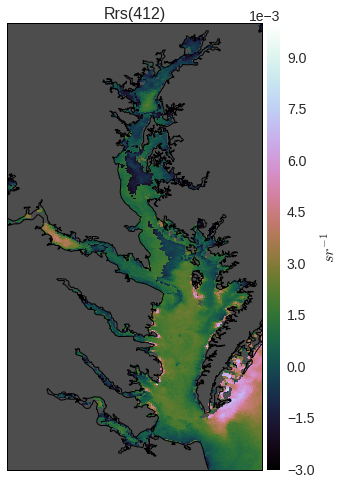

In [14]:
fig,ax = pl.subplots(figsize=(6,8))
data=rrs412
label='Rrs(412)'
fname='rrs412.png'
dataRng=(-0.3e-2,1.0e-2)
msn = Basemap(llcrnrlon=lonRng[0],llcrnrlat=latRng[0],
             urcrnrlon=lonRng[1],urcrnrlat=latRng[1],resolution='h',ax=ax)
msn.drawmeridians(np.arange(240,280,10),labels=[False]*3+[True])
msn.drawparallels(np.arange(-30,-10,10),labels=[True]+3*[False])
msn.drawmapboundary(fill_color='0.3')
msn.drawcoastlines()
ssn=pl.cm.ScalarMappable()
ssn.set_cmap('cubehelix')
ssn.set_clim(dataRng)
im = msn.pcolormesh(lons,lats,data,cmap=ssn.cmap,latlon=True,
                         norm=colors.Normalize(vmin=dataRng[0],vmax=dataRng[1]))
cb = msn.colorbar(im);
cb.set_label(r'$sr^{-1}$',size=16)
cb.formatter.set_powerlimits((-1,3))
cb.update_ticks()
ax.set_title(label,fontsize = 16)
fnpath = os.path.join(figsavedir,fname)
fig.savefig(fnpath,dpi=300)

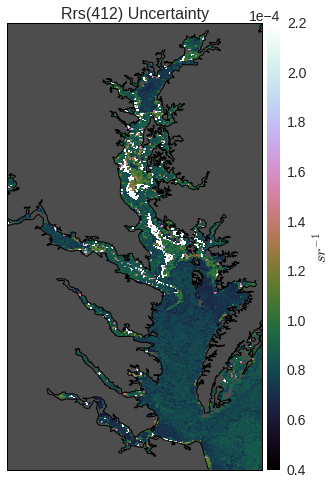

In [13]:
fig,ax = pl.subplots(figsize=(6,8))
data=rrs412Unc
label='Rrs(412) Uncertainty'
fname='rrs412U.png'
dataRng=(.4e-4,2.2e-4)
msn = Basemap(llcrnrlon=lonRng[0],llcrnrlat=latRng[0],
             urcrnrlon=lonRng[1],urcrnrlat=latRng[1],resolution='h',ax=ax)
msn.drawmeridians(np.arange(240,280,10),labels=[False]*3+[True])
msn.drawparallels(np.arange(-30,-10,10),labels=[True]+3*[False])
msn.drawmapboundary(fill_color='0.3')
msn.drawcoastlines()
ssn=pl.cm.ScalarMappable()
ssn.set_cmap('cubehelix')
ssn.set_clim(dataRng)
im = msn.pcolormesh(lons,lats,data,cmap=ssn.cmap,latlon=True,#vmin=dataRng[0],vmax=dataRng[1])
                         norm=colors.Normalize(vmin=dataRng[0],vmax=dataRng[1]))
cb = msn.colorbar(im);
cb.set_label(r'$sr^{-1}$',size=16)
cb.formatter.set_powerlimits((-1,3))
cb.update_ticks()
ax.set_title(label,fontsize = 16)
fnpath = os.path.join(figsavedir,fname)
fig.savefig(fnpath,dpi=300)

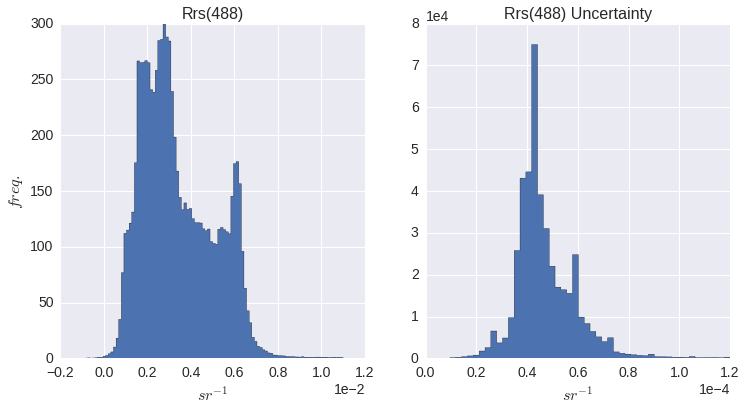

In [33]:
data=rrs488
rngL = (-1e-3,1.1e-2)
rngR = (0.5e-5,1.2e-4)
dataU=rrs488Unc
fname='rrs488dists.png'
ttlL='Rrs(488)'
ttlR='Rrs(488) Uncertainty'
DrawDists(data,dataU,rngL,rngR,fname,ttlL,ttlR,figsavedir)

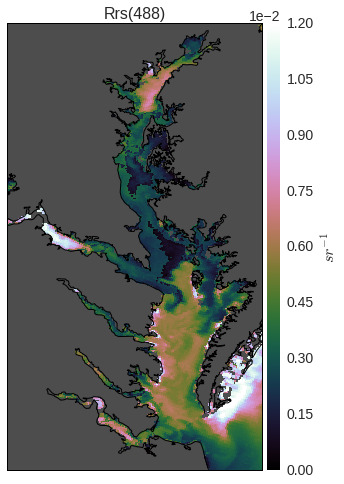

In [15]:
data = rrs488
label = 'Rrs(488)'
fname = 'rrs488.png'
rng = (0,1.2e-2)
DrawMap(data,label,fname,rng,figsavedir)

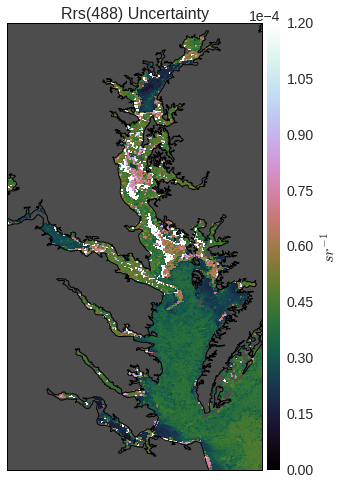

In [16]:
data = rrs488Unc
label = 'Rrs(488) Uncertainty'
fname = 'rrs488U.png'
rng = (0,1.2e-4)
DrawMap(data,label,fname,rng,figsavedir)

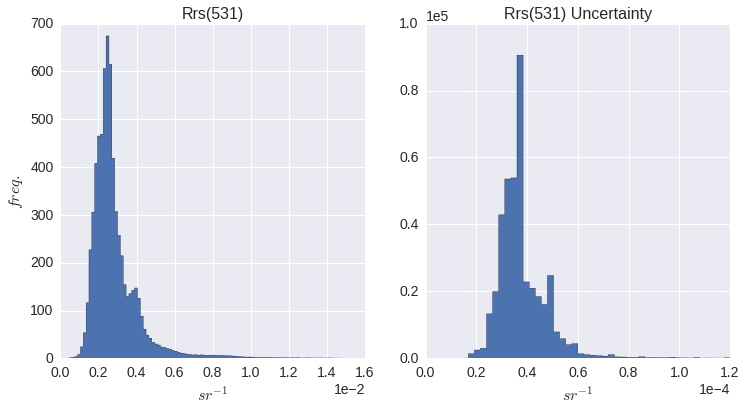

In [44]:
data=rrs531
rngL = (0,1.5e-2)
rngR = (0,1.2e-4)
dataU=rrs531Unc
fname='rrs531dists.png'
ttlL='Rrs(531)'
ttlR='Rrs(531) Uncertainty'
DrawDists(data,dataU,rngL,rngR,fname,ttlL,ttlR,figsavedir)

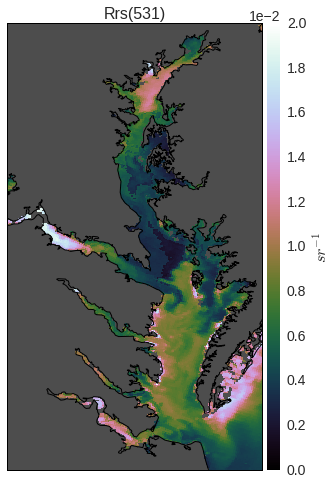

In [17]:
data = rrs531
label = 'Rrs(531)'
fname = 'rrs531.png'
rng = (0,2e-2)
DrawMap(data,label,fname,rng,figsavedir)

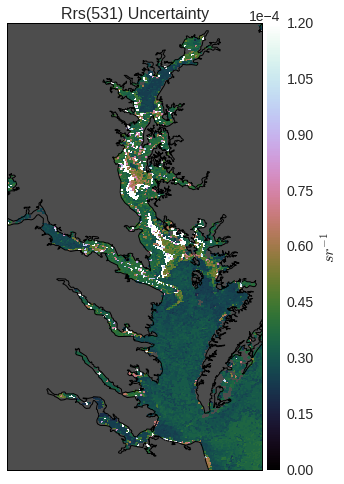

In [18]:
data = rrs531Unc
label = 'Rrs(531) Uncertainty'
fname = 'rrs531U.png'
rng = (0,1.2e-4)
DrawMap(data,label,fname,rng,figsavedir)

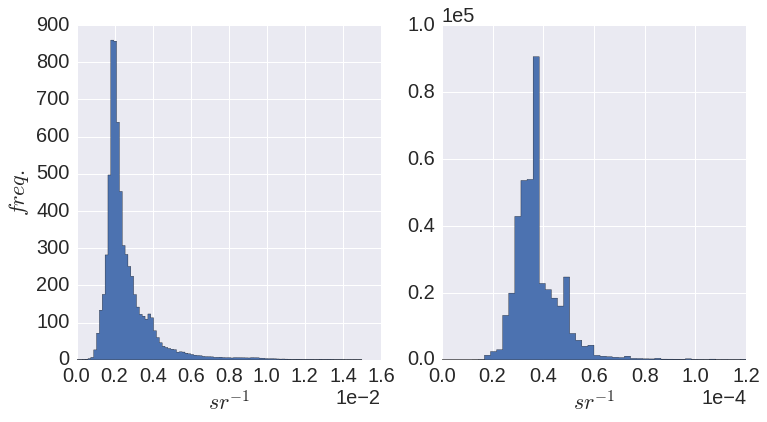

In [21]:
data=rrs547
rngL = (0,1.5e-2)
rngR = (0,1.2e-4)
dataU=rrs531Unc
fname='rrs547dists.png'
ttlL='Rrs(547)'
ttlR='Rrs(547) Uncertainty'
DrawDists(data,dataU,rngL,rngR,fname,ttlL,ttlR,figsavedir)

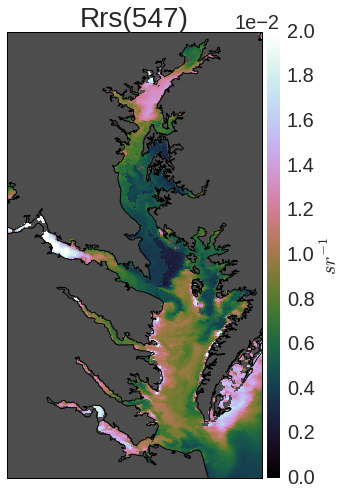

In [14]:
data = rrs547
label = 'Rrs(547)'
fname = 'rrs547.png'
rng = (0,2e-2)
DrawMap(data,label,fname,rng,figsavedir)

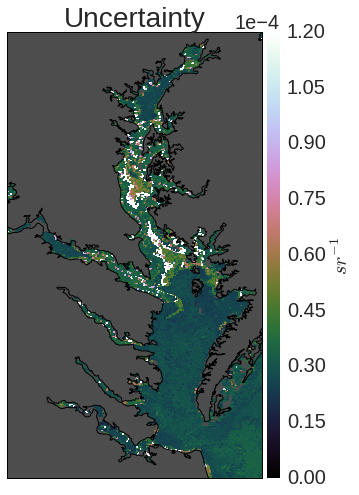

In [15]:
data = rrs547Unc
label = 'Uncertainty'
fname = 'rrs547U.png'
rng = (0,1.2e-4)
DrawMap(data,label,fname,rng,figsavedir)

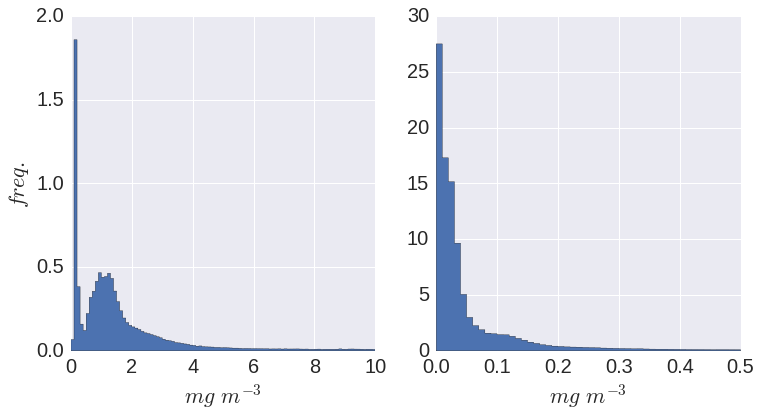

In [40]:
data=chlora
rngL = (0,10)
rngR = (0,.5)
dataU=chloraUnc
unitL = r'$mg \ m^{-3}$'
unitR = unitL
fname='chloradists.png'
ttlL='Chlorophyll a'
ttlR='Chlorophyll a Uncertainty'
#DrawDists(data,dataU,rngL,rngR,fname,ttlL,ttlR,figsavedir,xlabL=unitL,xlabR=unitR)
bins0,bins1,binsL,binsR,n0,n1 = DrawDists(data,dataU,rngL,rngR,fname,ttlL,ttlR,
                                          figsavedir,xlabL=unitL,xlabR=unitR,retnp=True)

In [41]:
db0 = np.diff(bins0,axis=0)

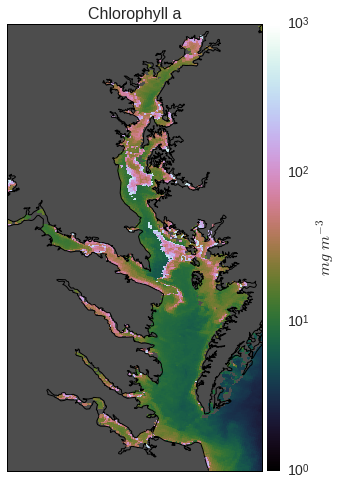

In [29]:
data = chlora
title = 'Chlorophyll a'
fname = 'chlora.png'
label = r'$mg \ m^{-3}$'
rng = (1,1e3)
DrawMap(data,title,fname,rng,figsavedir,normscale=False,lbl=label)

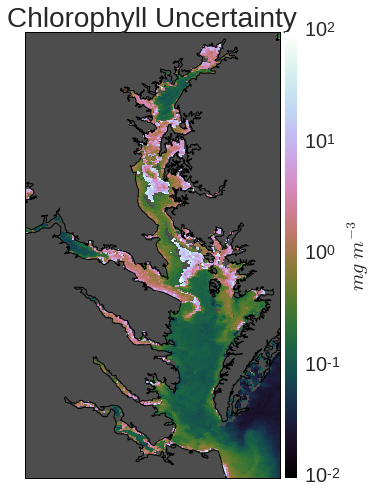

In [17]:
data = chloraUnc
title = 'Chlorophyll Uncertainty'
fname = 'chloraUnc.png'
label = r'$mg \ m^{-3}$'
rng = (1e-2,100)
DrawMap(data,title,fname,rng,figsavedir,normscale=False,lbl=label)

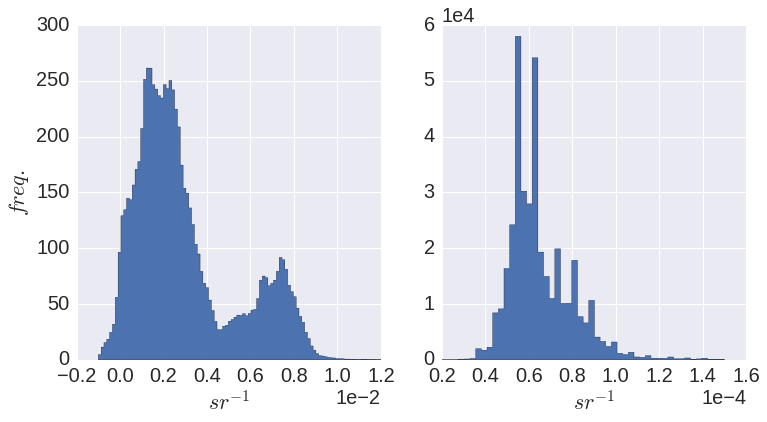

In [19]:
data=rrs443
rngL = (-1e-3,1.2e-2)
rngR = (0.2e-4,1.5e-4)
dataU=rrs443Unc
unitL = r'$sr^{-1}$'
unitR = unitL
fname='rrs443distsp.png'
ttlL='Rrs(443)'
ttlR='Rrs(443) Uncertainty'
#DrawDists(data,dataU,rngL,rngR,fname,ttlL,ttlR,figsavedir,xlabL=unitL,xlabR=unitR)
bins0,bins1,binsL,binsR,n0,n1 = DrawDists(data,dataU,rngL,rngR,fname,ttlL,ttlR,
                                          figsavedir,xlabL=unitL,xlabR=unitR,retnp=True)

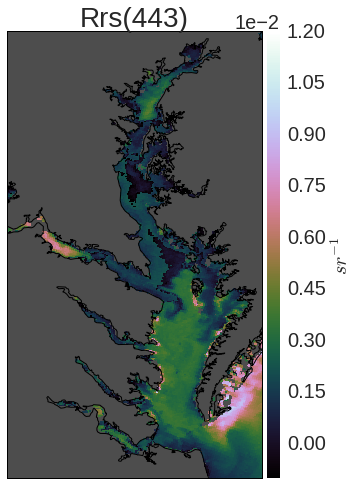

In [24]:
data = rrs443
label = 'Rrs(443)'
fname = 'rrs443.png'
rng = (-1e-3,1.2e-2)
DrawMap(data,label,fname,rng,figsavedir)

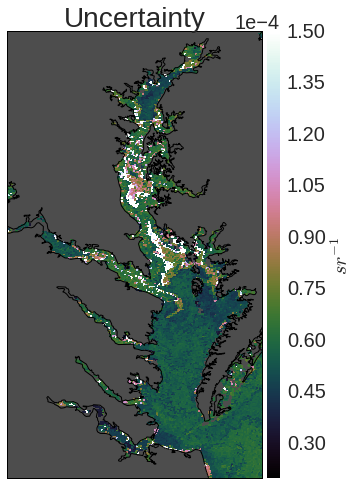

In [25]:
data = rrs443Unc
label = 'Uncertainty'
fname = 'rrs443U.png'
rng = (0.2e-4,1.5e-4)
DrawMap(data,label,fname,rng,figsavedir)